In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
sc = MinMaxScaler() # the MinMaxScaler is doing this: X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
url = 'https://raw.githubusercontent.com/josh-kennedy-7/cmu_msba_team_4_2022/main/consolidated_tuna_data_clean.csv'
df = pd.read_csv(url,index_col=0,parse_dates=[0],thousands=',')

In [ ]:
window_length = 5
training_perc = 0.7
training_set = df.loc[:,['skipjack_tuna_price']].values

def sliding_windows(data, window_length):
    x, y = [], []
    for i in range(len(data)-window_length-1):
        _x = data[i:(i+window_length)]
        _y = data[i+window_length]
        x.append(_x)
        y.append(_y)
    return np.array(x),np.array(y)

training_data = sc.fit_transform(training_set)
x, y = sliding_windows(training_data, window_length)
train_size = int(len(y) * training_perc)
test_size = len(y) - train_size
dataX, dataY = Variable(torch.Tensor(np.array(x))), Variable(torch.Tensor(np.array(y)))
trainX, trainY = Variable(torch.Tensor(np.array(x[0:train_size]))), Variable(torch.Tensor(np.array(y[0:train_size])))
testX, testY = Variable(torch.Tensor(np.array(x[train_size:len(x)]))), Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [ ]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.window_length = window_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [ ]:
num_epochs = 3000
learning_rate = 0.03
input_size = 1
hidden_size = 2
num_layers = 1
num_classes = 1
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()
    if epoch % 200 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.53661
Epoch: 200, loss: 0.00875
Epoch: 400, loss: 0.00837
Epoch: 600, loss: 0.00805
Epoch: 800, loss: 0.00749
Epoch: 1000, loss: 0.00690
Epoch: 1200, loss: 0.00681
Epoch: 1400, loss: 0.00675
Epoch: 1600, loss: 0.00669
Epoch: 1800, loss: 0.00649
Epoch: 2000, loss: 0.00609
Epoch: 2200, loss: 0.00602
Epoch: 2400, loss: 0.00596
Epoch: 2600, loss: 0.00586
Epoch: 2800, loss: 0.00576


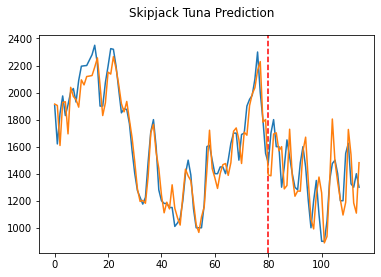

In [ ]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Skipjack Tuna Prediction')
plt.show()